I want to predict housing prices using data features (other than price), using machine learning methods. For this, I have taken a little help from the methods used in the following notebook.

- https://www.kaggle.com/code/raoofiali/divar-housing-adv


To predict the price, we go through the following steps:

## Import Libraries

In [1]:
pip install arabic_reshaper

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import arabic_reshaper
from bidi.algorithm import get_display

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
import os

## Load and Prepare Data

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/divar-house-adv-dataset/housing-Raoofi.csv


In [4]:
Housing_data = pd.read_csv('/kaggle/input/divar-house-adv-dataset/housing-Raoofi.csv')
Housing_data.head()

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price
0,153,1393,3,True,True,True,۱ ساعت پیش در تهران، درکه,۱۸٬۳۶۰٬۰۰۰٬۰۰۰ تومان
1,418,1382,4,True,True,True,۱ ساعت پیش در تهران، زعفرانیه,۱۳۰٬۰۰۰٬۰۰۰٬۰۰۰ تومان
2,57,1385,2,False,False,True,۱ ساعت پیش در تهران، جابری,۲٬۶۰۰٬۰۰۰٬۰۰۰ تومان
3,193,1371,3,False,False,True,۱ ساعت پیش در تهران، فرمانیه,۲۳٬۰۰۰٬۰۰۰٬۰۰۰ تومان
4,62,1401,1,True,True,True,۱ ساعت پیش در تهران، دهکده المپیک، بزرگراه همت...,۱٬۴۱۰٬۰۰۰٬۰۰۰ تومان


In [5]:
Housing_data.shape

(94036, 8)

## PreProcessing _ Part 1

One of the important steps in data analysis and modeling by machine learning is data preprocessing, which can be done before or after EDA. In this project, we do this step in two parts before and after EDA because it is necessary to make changes to the model for better understanding of the model and visualization. We will do the rest of the preprocessing after rendering and before training the model.

In [6]:
Housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94036 entries, 0 to 94035
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Area          94036 non-null  object
 1   Construction  94036 non-null  object
 2   Room          94036 non-null  object
 3   Warehouse     94036 non-null  object
 4   Parking       94036 non-null  object
 5   Elevator      94036 non-null  object
 6   Address       94036 non-null  object
 7   Price         94036 non-null  object
dtypes: object(8)
memory usage: 5.7+ MB


In [7]:
Housing_data[Housing_data['Price']=='توافقی']

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price
295,80,1399,2,True,True,True,۱ ساعت پیش در تهران، اقدسیه,توافقی
704,72,1401,2,True,True,True,۲ ساعت پیش در تهران، مبارک‌آباد بهشتی,توافقی
874,460,1401,4,True,True,True,۲ ساعت پیش در تهران، الهیه,توافقی
881,935,1400,4,True,True,True,۲ ساعت پیش در تهران، الهیه,توافقی
900,418,1401,4,True,True,True,۲ ساعت پیش در تهران، الهیه,توافقی
...,...,...,...,...,...,...,...,...
88099,120,1400,2,True,True,True,۲ هفته پیش در تهران، سعادت‌آباد,توافقی
88513,100,1401,2,True,True,True,۲ هفته پیش در تهران، چیتگر,توافقی
88624,160,1395,3,True,True,True,۳ روز پیش در تهران، مرزداران,توافقی
91441,360,1400,4,True,True,True,۲ هفته پیش در تهران، پاسداران,توافقی


In [8]:
def clean_price(price):
    if 'تومان' in price:
        return int(price.replace('تومان', '').replace('٬', '').strip())
    return None

In [9]:
Housing_data['Price'] = Housing_data['Price'].apply(clean_price)
Housing_data = Housing_data.dropna(subset=['Price'])
Housing_data.reset_index(drop=True, inplace=True)

For the address column, it is necessary to remove the time of uploading the ad, as well as the more detailed part of the address, and only place the name of the neighborhood in the correct form.

In [10]:
def clean_Address(address):

    match = re.search(r'پیش در تهران، ([^،]+)(?:، [^،]+)?$', address)
    if match:
        return match.group(1)
    return address

Housing_data['Address'] = Housing_data['Address'].apply(clean_Address)
Housing_data

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price
0,153,1393,3,True,True,True,درکه,1.836000e+10
1,418,1382,4,True,True,True,زعفرانیه,1.300000e+11
2,57,1385,2,False,False,True,جابری,2.600000e+09
3,193,1371,3,False,False,True,فرمانیه,2.300000e+10
4,62,1401,1,True,True,True,دهکده المپیک,1.410000e+09
...,...,...,...,...,...,...,...,...
93785,181,1393,3,True,True,True,جردن,1.800000e+10
93786,121,1400,3,True,True,True,اباذر,1.380000e+10
93787,140,1400,3,True,True,True,آبشار تهران,9.860000e+09
93788,105,1398,2,True,True,True,اوقاف,6.430000e+09


In [11]:
l =[]
for i in range(1300, 1402):
    l.append(str(i))

def v(Construction):
    if isinstance(Construction, str):
        if Construction in l:
            return int(Construction)
        else:
            return 'Unknown'
    else:
        return Construction

In [12]:
Housing_data['Construction'] = Housing_data['Construction'].apply(v)

In [13]:
A = [str(i) for i in range(0, 10000)]

def p(Area):
    if isinstance(Area, str):
        if Area in A:
            return int(Area)
        else:
            return np.nan
    elif isinstance(Area, int):
        return Area

In [14]:
Housing_data['Area'] = Housing_data['Area'].apply(p)

In [15]:
Housing_data = Housing_data[Housing_data['Construction']!= 'Unknown']

In [16]:
Housing_data = Housing_data.dropna(subset=['Area'])
Housing_data['Area'] = Housing_data['Area'].astype(int)

In [17]:
Housing_data.drop_duplicates(inplace= True)

In [18]:
Housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89497 entries, 0 to 93789
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          89497 non-null  int64  
 1   Construction  89497 non-null  int64  
 2   Room          89497 non-null  object 
 3   Warehouse     89497 non-null  object 
 4   Parking       89497 non-null  object 
 5   Elevator      89497 non-null  object 
 6   Address       89497 non-null  object 
 7   Price         89497 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 6.1+ MB


In [19]:
l =[]
for i in range(1, 5):
    l.append(str(i))

def Room(Room):
    if isinstance(Room, str):
        if Room in l:
            return int(Room)
        else:
            return 'Unknown'
    else:
        return Room

In [20]:
Housing_data['Room'] = Housing_data['Room'].apply(Room)

In [21]:
Housing_data['Warehouse'] = Housing_data['Warehouse'].astype(str)
Housing_data['Warehouse'] = Housing_data['Warehouse'].map({'True': True, 'False': False, 'true': True, 'false': False, True: True, False: False})

Housing_data['Parking'] = Housing_data['Parking'].astype(str)
Housing_data['Parking'] = Housing_data['Parking'].map({'True': True, 'False': False, 'true': True, 'false': False, True: True, False: False})

Housing_data['Elevator'] = Housing_data['Elevator'].astype(str)
Housing_data['Elevator'] = Housing_data['Elevator'].map({'True': True, 'False': False, 'true': True, 'false': False, True: True, False: False})

In [22]:
Housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89497 entries, 0 to 93789
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          89497 non-null  int64  
 1   Construction  89497 non-null  int64  
 2   Room          89497 non-null  int64  
 3   Warehouse     89497 non-null  bool   
 4   Parking       89497 non-null  bool   
 5   Elevator      89497 non-null  bool   
 6   Address       89497 non-null  object 
 7   Price         89497 non-null  float64
dtypes: bool(3), float64(1), int64(3), object(1)
memory usage: 4.4+ MB


In [23]:
Housing_data.Address.nunique()

337

As it is clear above, the houses registered in this dataset are distributed in 337 different neighborhoods.

## EDA & Visualization

In [24]:
Housing_data.columns

Index(['Area', 'Construction', 'Room', 'Warehouse', 'Parking', 'Elevator',
       'Address', 'Price'],
      dtype='object')

This dataset contains information about the houses listed on the 'Divar' site, for each house the following 8 characteristics are collected:

- 'Area': Apartment area (square meters)
- 'Construction': Year of construction
- 'Room': Number of Room
- 'Warehouse': This is True if the property has Warehouse 
- 'Parking': This is True if the property has Parking 
- 'Elevator': This is True if the property has an Elevator
- 'Address': Location
- 'Price': in Toman (Iranian Currency) 

In [25]:
Housing_data.describe()

,Area,Construction,Room,Price
count,89497.000000,89497.000000,89497.000000,8.949700e+04
mean,123.186263,1392.808116,2.225449,1.453441e+10
std,199.798156,7.749285,0.769985,2.675891e+10
min,1.000000,1371.000000,1.000000,2.300000e+08
25%,74.000000,1386.000000,2.000000,4.900000e+09
50%,105.000000,1395.000000,2.000000,8.600000e+09
75%,141.000000,1400.000000,3.000000,1.550000e+10
max,36500.000000,1401.000000,4.000000,1.000000e+12


- According to the above information, the average construction of all houses was in 1392-1393. The oldest house is in 1371 and the newest is in 1401

- The average size of the houses is about 125 square meters. Also, the smallest house is 1 cubic meter and the largest house is 36,500 cubic meters.

- The average number of rooms is 2 rooms. Also, the minimum number of rooms is 1 and the maximum number of rooms is 4.

- The average price of all houses in this dataset is 14.5 billion tomans. Also, the cheapest house is 230 million Tomans and the most expensive house is 1000 billion Tomans.

In [26]:
Housing_data.Parking.value_counts(normalize=True)

Parking
True     0.869694
False    0.130306
Name: proportion, dtype: float64

In [27]:
Housing_data.Elevator.value_counts(normalize=True)

Elevator
True     0.946836
False    0.053164
Name: proportion, dtype: float64

In [28]:
Housing_data.Warehouse.value_counts(normalize=True)

Warehouse
True     0.806809
False    0.193191
Name: proportion, dtype: float64

According to the above information, about 87% of the houses in this dataset have parking spaces. Also, about 95% of these houses have elevators. 81% of them also have a warehouse. This statistic can also be seen in the chart below.

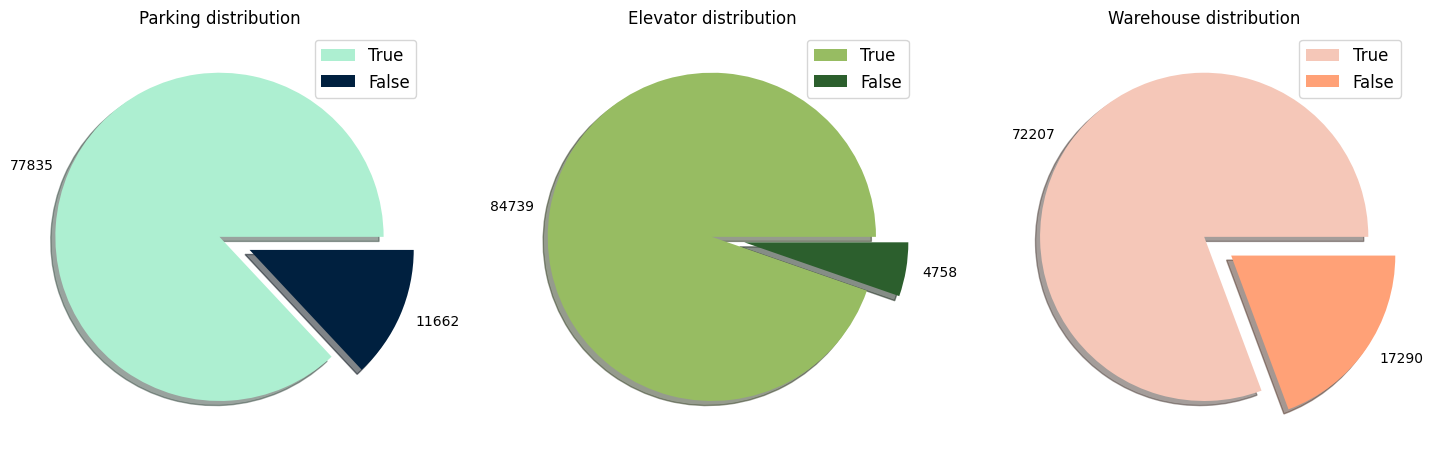

In [29]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))

colors = [['#ADEFD1FF', '#00203FFF'], ['#97BC62FF', '#2C5F2D'], ['#F5C7B8FF', '#FFA177FF']]
explode = [0, 0.2]
columns = ['Parking', 'Elevator', 'Warehouse']
for i in range(3):
        data = Housing_data[columns[i]].value_counts()
        ax[i].pie(data, labels=data.values, explode=explode, colors=colors[i], shadow=True)
        ax[i].legend(labels=data.index, fontsize='large')
        ax[i].set_title('{} distribution'.format(columns[i]))

In [30]:
pd.crosstab(Housing_data.Elevator, Housing_data.Room)

Room,1,2,3,4
Elevator,,,,
False,2017,2277,428,36
True,12890,41038,27038,3773


<Axes: xlabel='Room', ylabel='count'>

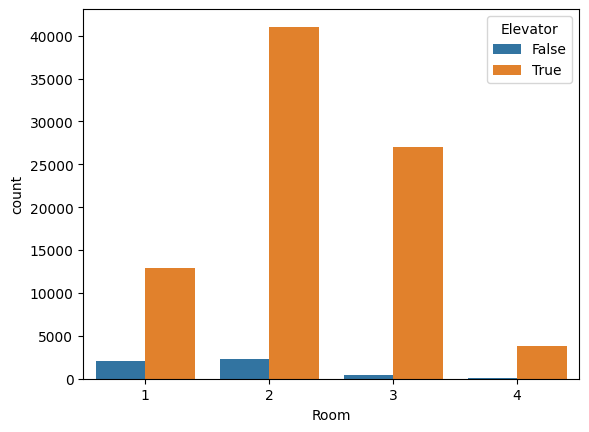

In [31]:
sns.countplot(Housing_data, x = 'Room', hue='Elevator')

In [32]:
pd.crosstab(Housing_data.Warehouse, Housing_data.Room)

Room,1,2,3,4
Warehouse,,,,
False,7269,8757,1141,123
True,7638,34558,26325,3686


<Axes: xlabel='Room', ylabel='count'>

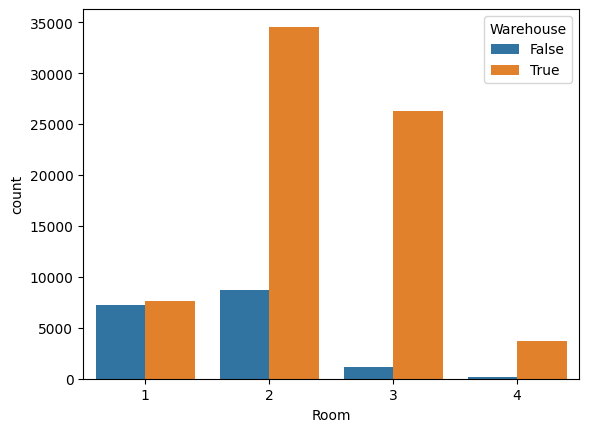

In [33]:
sns.countplot(Housing_data, x = 'Room', hue='Warehouse')

In [34]:
pd.crosstab(Housing_data.Parking, Housing_data.Room)

Room,1,2,3,4
Parking,,,,
False,6441,4781,390,50
True,8466,38534,27076,3759


<Axes: xlabel='Room', ylabel='count'>

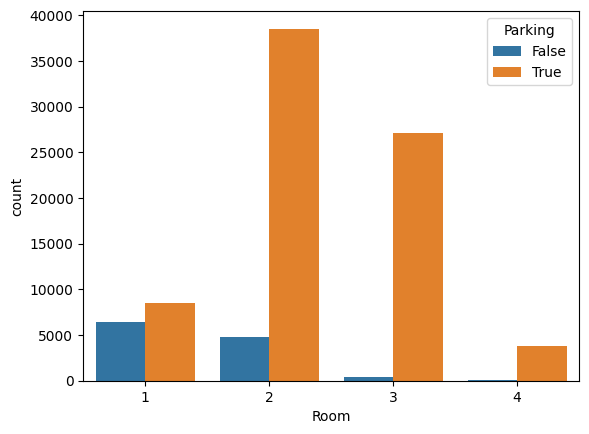

In [35]:
sns.countplot(Housing_data, x = 'Room', hue='Parking')

According to the information and charts above, the more the number of rooms, the more likely the house has an elevator.
These ratios also apply to parking and storage, which means that the more rooms there are, the more likely it is that the house has a storage and parking.

In [36]:
Hous_mean = Housing_data.groupby('Room')['Price'].mean()
Hous_mean

Room
1    3.858189e+09
2    8.384872e+09
3    2.206365e+10
4    7.195625e+10
Name: Price, dtype: float64

In [37]:
House_Price = pd.DataFrame(Housing_data.groupby('Address')['Price'].mean().sort_values(ascending=False))
House_Price

,Price
Address,
الهیه,5.880078e+10
زعفرانیه,5.694506e+10
محمودیه,4.966095e+10
کامرانیه,4.895503e+10
ولنجک,4.877739e+10
...,...
شهرک آسمان,1.675000e+09
شریف‌آباد,1.445250e+09
صالح‌آباد شرقی,1.100000e+09


The above table shows the average price of houses according to the respective neighborhood. According to these data, the most expensive houses are located in "Elahia" neighborhood with an average price of 59 billion tomans. Also, the prices of houses in "Zafaranieh" and "Kamraniyeh" are the second and third most expensive houses with an average of 57 and 51 billion tomans.
Also, the cheapest houses are located in "Karimabad" neighborhood with an average of 1 billion and then in "Hassanabad Bagharfar" and "Salehabad East" neighborhoods with an average of 1 billion and 100 million tomans.


The graph below shows the average price of 15 expensive and 15 cheap neighborhoods 

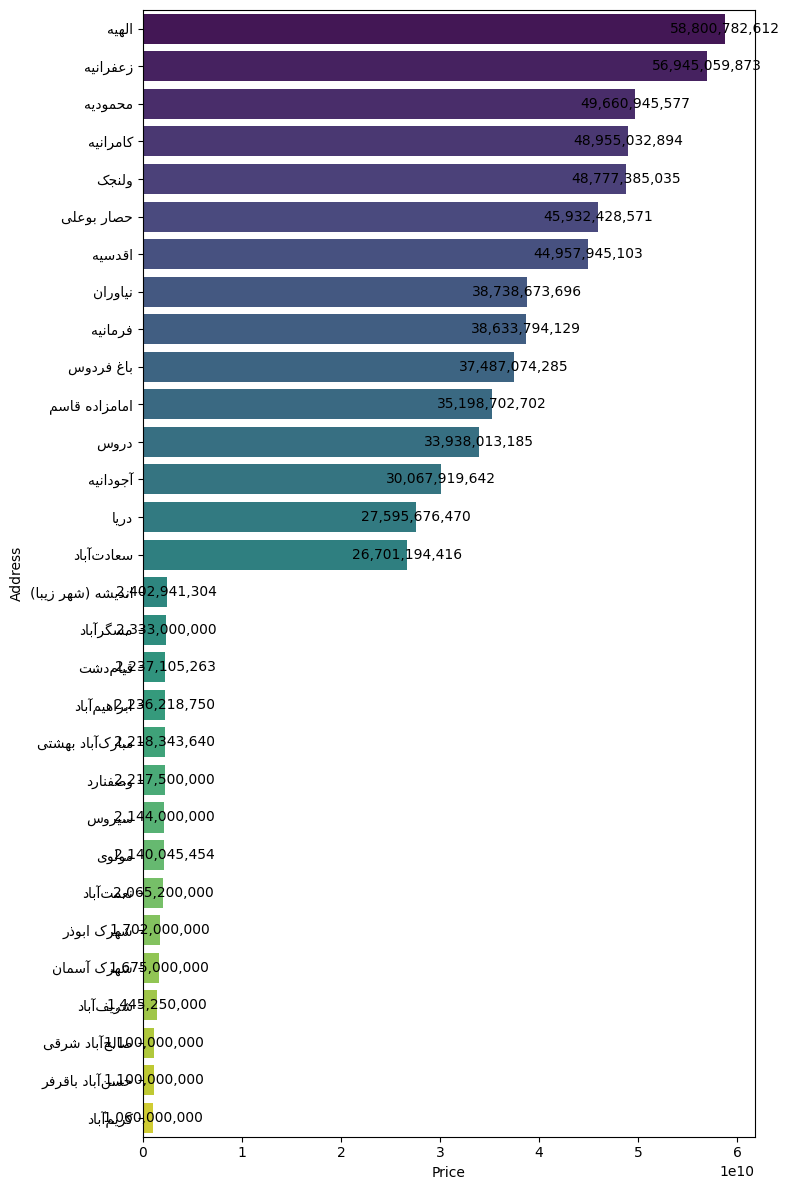

In [38]:
House_Price_1 = pd.DataFrame(pd.concat([House_Price.head(15), House_Price.tail(15)])).reset_index()
House_Price_1['Address'] = House_Price_1['Address'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))

fig, ax = plt.subplots(figsize=(8, 12)) 

plt.rcParams['font.family'] = 'DejaVu Sans'

sns.barplot(data=House_Price_1, y='Address', x='Price', ax=ax, palette='viridis')

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 5, 
             p.get_y() + p.get_height() / 2,  
             f'{int(width):,}', 
             ha='center', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

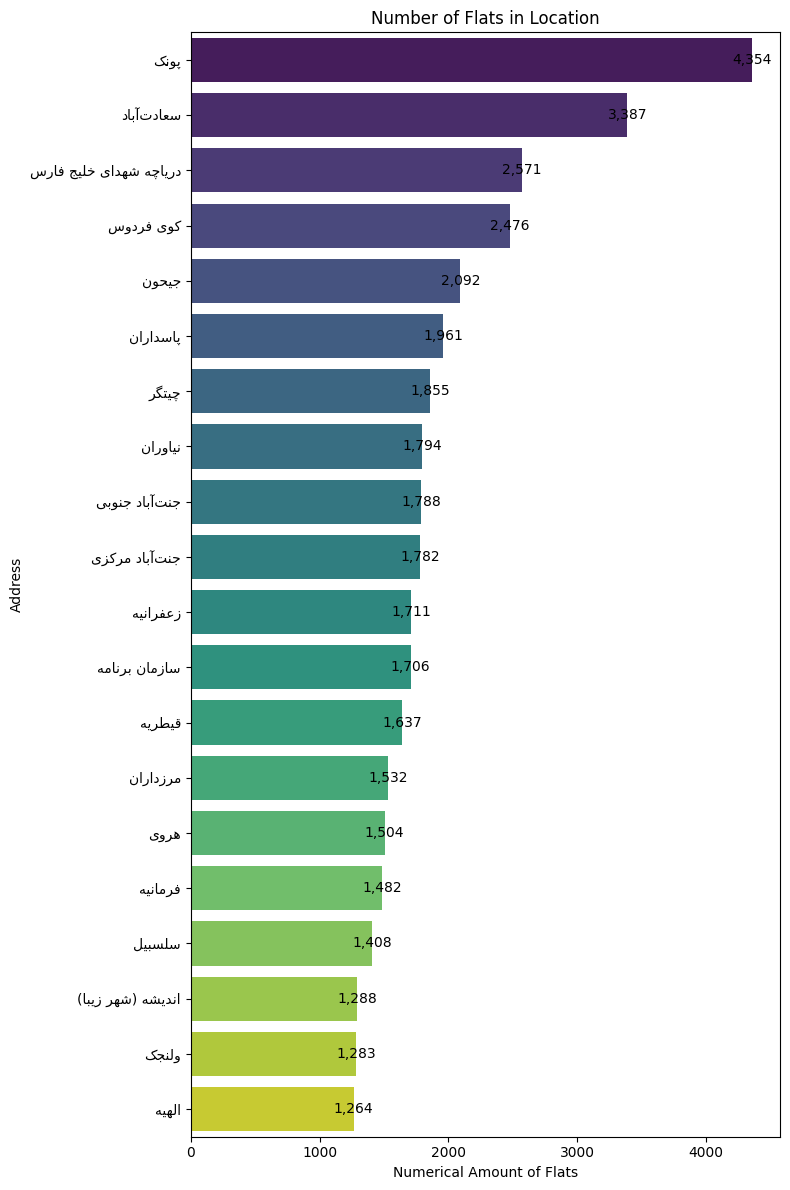

In [39]:
df = Housing_data['Address'].apply(lambda x: get_display(arabic_reshaper.reshape(x))).value_counts().sort_values(ascending=False)
df = df[:20]

fig, ax = plt.subplots(figsize=(8, 12))

plt.rcParams['font.family'] = 'DejaVu Sans'

sns.barplot(x=df.values, y=df.index, ax=ax, palette='viridis')

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 1, 
             p.get_y() + p.get_height() / 2, 
             f'{int(width):,}',  
             ha='center', va='center', fontsize=10, color='black')

plt.xlabel('Numerical Amount of Flats')
plt.title('Number of Flats in Location')

plt.tight_layout()
plt.show()

The chart above shows the 20 neighborhoods with the highest number of homes advertised.

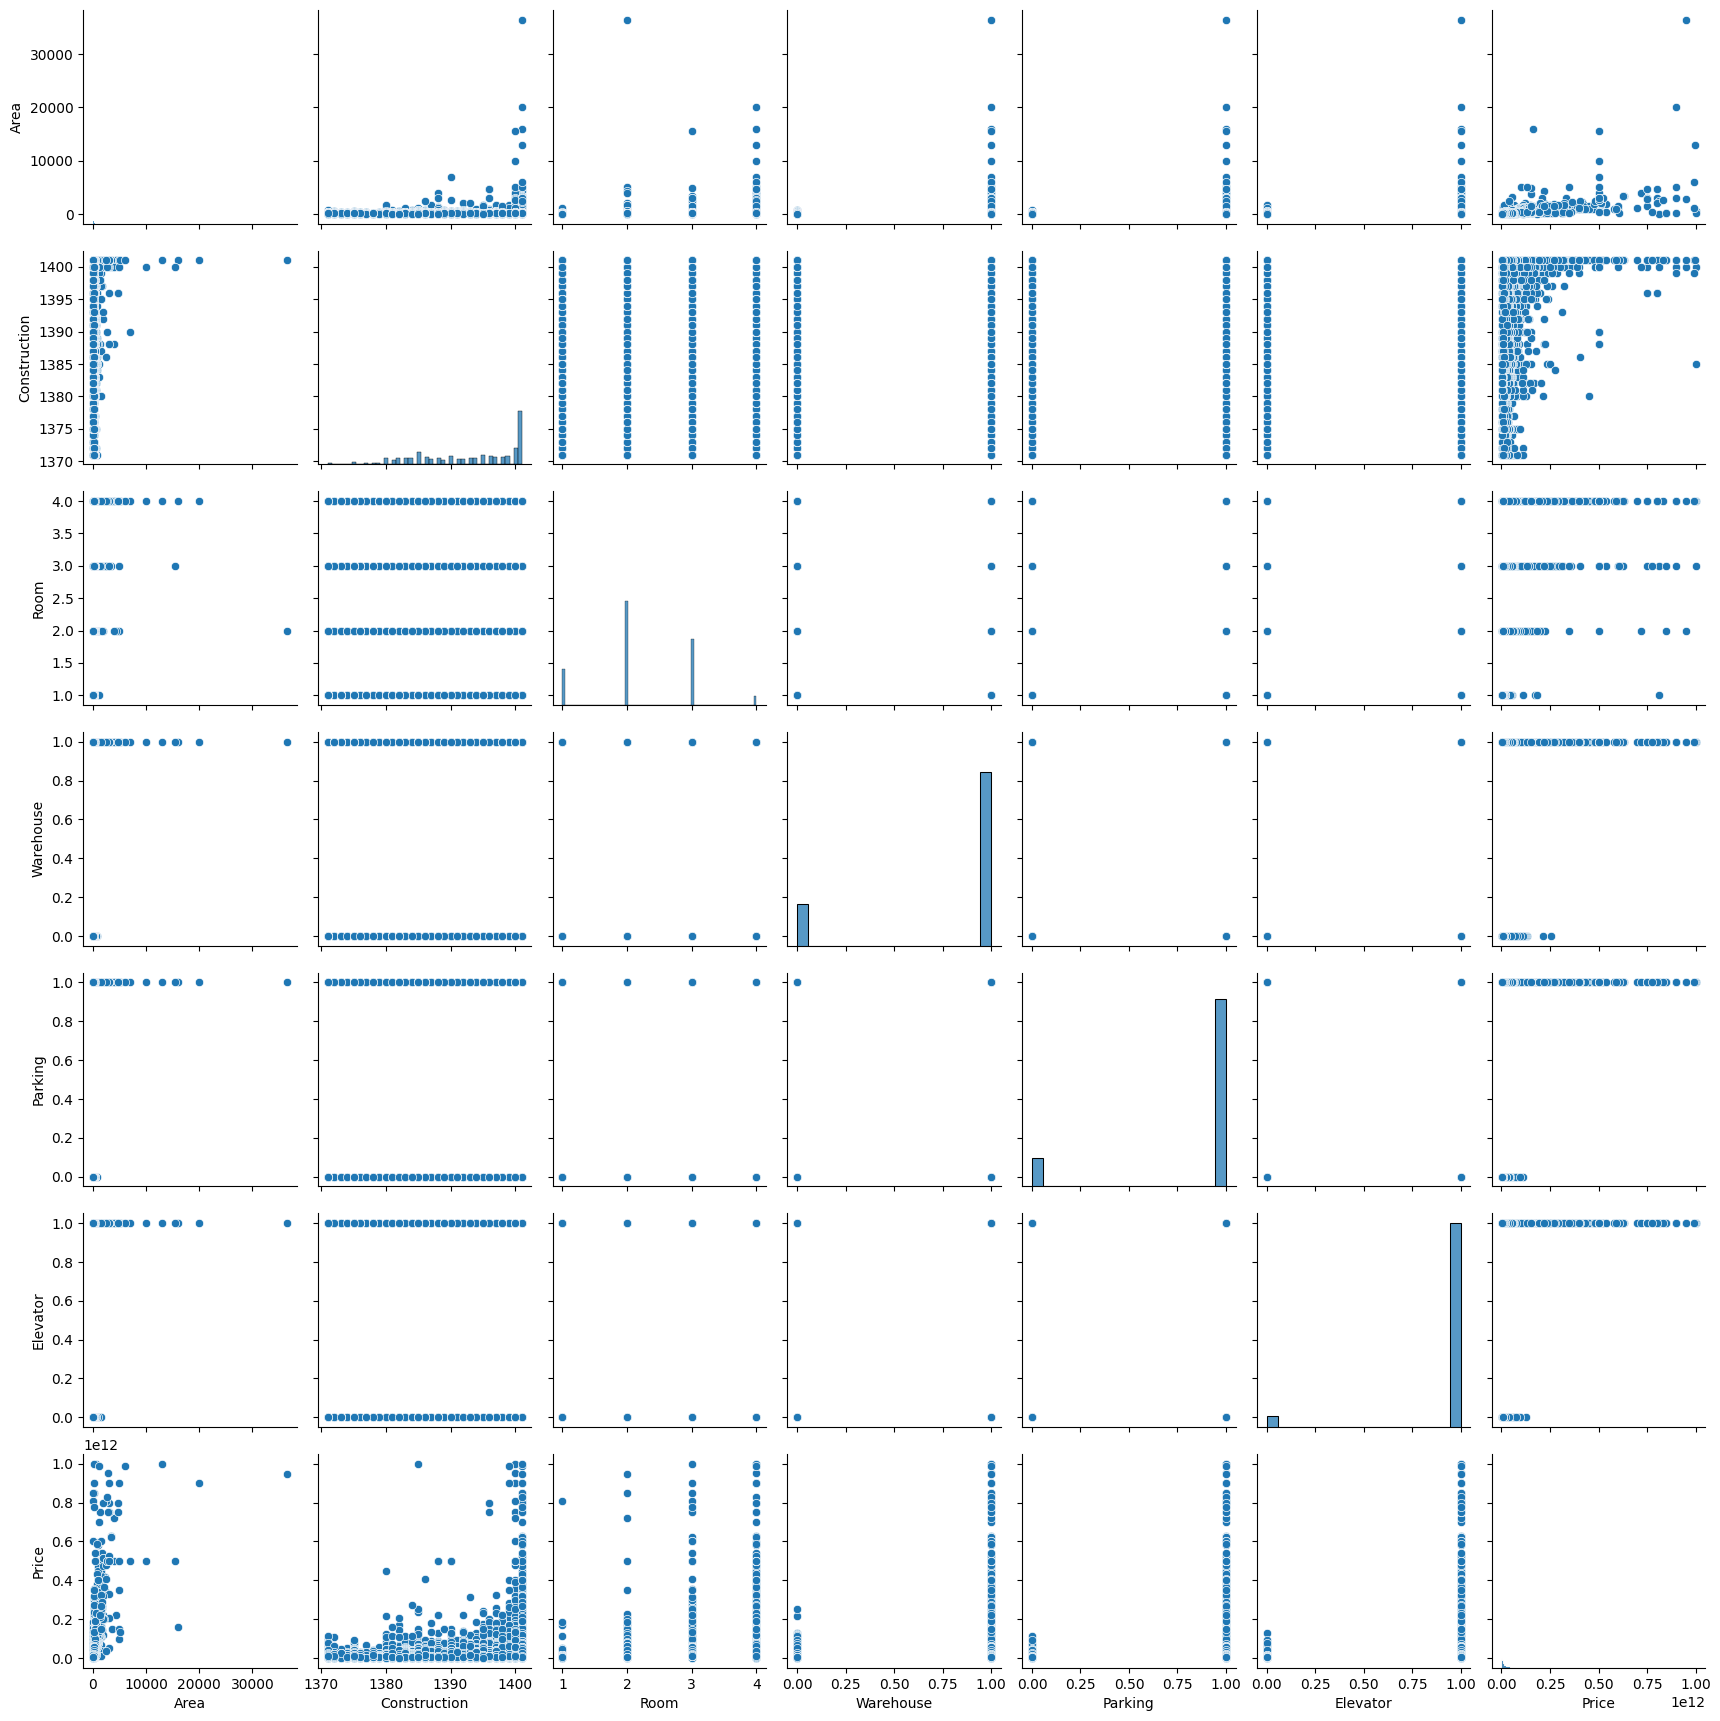

In [40]:
sns.pairplot(data=Housing_data)

The above chart compares the features in the data set two by two.
The following results can be obtained from these graphs.


- The newer the house, the higher the price, except for outliers
- The less the number of rooms, the cheaper the house
- If the house has parking, storage or elevator, the price of the house will increase.
- Larger houses are often built in recent years.
- All the houses that don't have parking, storage and elevator are small in size

## PreProcessing _ Part 2

In this section, we will first check the distribution of the data and whether there are outliers in the data or not. If there are any, we remove them and continue the rest of the preprocessing process to prepare the data for training.

In [41]:
Housing_data['m'] = Housing_data['Price'] / Housing_data['Area']

In [42]:
def m(m):
    if (isinstance(m, float)):
        return m
    elif (isinstance(m, int)):
        return m
    else:
        return np.nan

In [43]:
Housing_data['m'] = Housing_data['m'].apply(m)
Housing_data

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price,m
0,153,1393,3,True,True,True,درکه,1.836000e+10,1.200000e+08
1,418,1382,4,True,True,True,زعفرانیه,1.300000e+11,3.110048e+08
2,57,1385,2,False,False,True,جابری,2.600000e+09,4.561404e+07
3,193,1371,3,False,False,True,فرمانیه,2.300000e+10,1.191710e+08
4,62,1401,1,True,True,True,دهکده المپیک,1.410000e+09,2.274194e+07
...,...,...,...,...,...,...,...,...,...
93785,181,1393,3,True,True,True,جردن,1.800000e+10,9.944751e+07
93786,121,1400,3,True,True,True,اباذر,1.380000e+10,1.140496e+08
93787,140,1400,3,True,True,True,آبشار تهران,9.860000e+09,7.042857e+07
93788,105,1398,2,True,True,True,اوقاف,6.430000e+09,6.123810e+07


In [44]:
c = 1
p = 0
Housing_data = Housing_data.copy()
zone = list(Housing_data.Address.unique())
for i in zone:
    m = Housing_data[Housing_data['Address'] == i]['m'].mean()
    s = Housing_data[Housing_data['Address'] == i]['m'].std() 
    c +=1 
    print(i, c)
    for j in Housing_data[Housing_data['Address'] == i].index:
        if (Housing_data.loc[j]['m'] > m + 3*s) or (Housing_data.loc[j]['m'] < m - 3 * s):
            Housing_data.drop(j, inplace= True)
            p += 1
    print(p)

درکه 2
2
زعفرانیه 3
9
جابری 4
9
فرمانیه 5
28
دهکده المپیک 6
29
حکیمیه 7
30
شهرک غرب 8
46
سعادت‌آباد 9
67
خاوران 10
67
سازمان آب 11
70
مرزداران 12
75
دارآباد 13
75
الهیه 14
83
شاهین 15
85
شهر زیبا 16
86
سازمان برنامه 17
94
باغ فیض 18
95
جنت‌آباد مرکزی 19
96
پونک 20
100
نیاوران 21
104
جیحون 22
110
سیدخندان 23
112
نارمک 24
126
سهروردی 25
128
ازگل 26
129
چیتگر 27
131
دروس 28
137
هروی 29
139
جمهوری 30
140
تهرانپارس غربی 31
143
دریاچه شهدای خلیج فارس 32
156
نیلوفر 33
157
میرداماد 34
159
قیطریه 35
165
سوهانک 36
168
کوی فردوس 37
171
جنت‌آباد جنوبی 38
173
تهران‌سر 39
178
استاد معین 40
180
اختیاریه 41
183
طیب 42
183
ستارخان 43
186
کاظم‌آباد 44
187
شهرک ولیعصر 45
189
دریا 46
191
شهران جنوبی 47
197
ونک 48
199
حصار بوعلی 49
201
شهرک پرواز 50
202
بهار 51
204
گیشا (کوی نصر) 52
205
المهدی 53
205
اباذر 54
208
شکوفه 55
209
شمس‌آباد 56
210
کوی فراز 57
210
شهرک نفت (منطقه ۵) 58
212
اندیشه (شهر زیبا) 59
247
سرو آزاد 60
247
جردن 61
249
آذربایجان 62
251
بلوار کشاورز 63
251
میدان حر 64
251
شهران شمالی 65
270


In [45]:
Housing_data.shape

(89032, 9)

As it is known, warehouse, parking and elevator data are of binary type that can be converted to 0-1. Also, the data related to the location of the house is of the object type, which needs to be converted into a numerical value.

There are several ways to encode data:

- Replace with arbitrary values
- labelencoding method
- Onehot encoding method

In the first two methods, since the number of classes is diverse and large and it is supposed to be filled from 1 to 337, this feature may be mistaken for different weight data, so it is better to use the onehot encoding method to calculate the correct weight for each location.

In [46]:
address_dummy = pd.get_dummies(Housing_data['Address'], drop_first=True)

Housing_data_final = Housing_data.merge(address_dummy, left_index=True, right_index=True)

Housing_data_final.drop(columns='Address', inplace=True)

bool_columns = Housing_data_final.select_dtypes(include='bool').columns
Housing_data_final[bool_columns] = Housing_data_final[bool_columns].astype(int)

Housing_data_final.head()

,Area,Construction,Room,Warehouse,Parking,Elevator,Price,m,آبشار تهران,آجودانیه,...,کوی هفدهم شهریور,گاندی,گرگان,گلاب دره,گلچین,گمرک,گیشا (کوی نصر),یاخچی‌آباد,یافت‌آباد,یوسف‌آباد
0,153,1393,3,1,1,1,1.836000e+10,1.200000e+08,0,0,...,0,0,0,0,0,0,0,0,0,0
1,418,1382,4,1,1,1,1.300000e+11,3.110048e+08,0,0,...,0,0,0,0,0,0,0,0,0,0
2,57,1385,2,0,0,1,2.600000e+09,4.561404e+07,0,0,...,0,0,0,0,0,0,0,0,0,0
3,193,1371,3,0,0,1,2.300000e+10,1.191710e+08,0,0,...,0,0,0,0,0,0,0,0,0,0
4,62,1401,1,1,1,1,1.410000e+09,2.274194e+07,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
Housing_data_final['Construction'] = 1403 - Housing_data_final['Construction']
Housing_data_final['Construction'] = Housing_data_final['Construction'].apply(lambda x: 30 if x > 30 else x)
Housing_data_final.head(3)

,Area,Construction,Room,Warehouse,Parking,Elevator,Price,m,آبشار تهران,آجودانیه,...,کوی هفدهم شهریور,گاندی,گرگان,گلاب دره,گلچین,گمرک,گیشا (کوی نصر),یاخچی‌آباد,یافت‌آباد,یوسف‌آباد
0,153,10,3,1,1,1,1.836000e+10,1.200000e+08,0,0,...,0,0,0,0,0,0,0,0,0,0
1,418,21,4,1,1,1,1.300000e+11,3.110048e+08,0,0,...,0,0,0,0,0,0,0,0,0,0
2,57,18,2,0,0,1,2.600000e+09,4.561404e+07,0,0,...,0,0,0,0,0,0,0,0,0,0


Above, we calculate the age of the house up to today's date, and since houses over 30 years old are dilapidated, we consider the same 30 for numbers over 30.

Also, by testing the model in different modes, we came to the conclusion that the combination of home facilities such as storage, parking and elevator together with the sum of these features gives better results.

In [48]:
Housing_data_final['facilities'] = Housing_data_final['Warehouse'] + Housing_data_final['Parking'] + Housing_data_final['Elevator']
Housing_data_final.drop(columns=['Warehouse', 'Parking', 'Elevator'], inplace=True)

## Training Model

In [49]:
# Split train and test

Data = Housing_data_final.drop(columns = ['Price','m'])
Price = Housing_data_final['Price']
x_train, x_test, y_train, y_test = train_test_split(Data,Price,test_size=0.25,train_size=0.75)
print(f"shape of x train: {x_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {x_test.shape}")
print(f"shape of y train: {y_test.shape}")

shape of x train: (66774, 340)
shape of y train: (66774,)
shape of x test: (22258, 340)
shape of y train: (22258,)


In this section, we need to check whether the data is normal or not. If necessary, normalize the training data. This normalization should only be done on feature data, not price (which is the target data).

In [50]:
# Normalization

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

Here two KNN and Random forest models are applied to the data set with the following parameters to select the best model.

In [51]:
def find_Parameters__(model, parameters):

    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=1, cv=cv)
    grid_result = grid_search.fit(X_train_scaled, y_train)

    best_params = grid_result.best_params_

    model = model.set_params(**best_params)
    accuracies = cross_val_score(estimator = model, X = X_train_scaled, y = y_train, cv = cv, scoring='r2')

    Accuracy_CrossVal = "{:.2f} %".format(accuracies.mean()*100)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Calculate performance metrics
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))


    model_name = str(model).split('(')[0]
        
    print(f"The best parameters for {model_name} model is: {best_params}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {rmse:,} for {model_name} model.")
    print("--" * 10)
    return train_score, test_score, rmse, Accuracy_CrossVal

In [52]:
rfr = RandomForestRegressor(random_state = 1, n_jobs = -1)
param_rfr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

rfr_train_score, rfr_test_score, rfr_RMSE , Accuracy_CrossVal= find_Parameters__(rfr, param_rfr)

The best parameters for RandomForestRegressor model is: {'min_samples_leaf': 2, 'min_samples_split': 2}
--------------------
(R2 score) in the training set is 94.39% for RandomForestRegressor model.
(R2 score) in the testing set is 85.66% for RandomForestRegressor model.
RMSE is 8,420,608,246.407034 for RandomForestRegressor model.
--------------------


In [53]:
knr = KNeighborsRegressor(n_jobs = 1)
param_knr = {'n_neighbors': [5, 10, 15, 20]}

knr_train_score, knr_test_score, knr_RMSE, knr_Accuracy_crossVal = find_Parameters__(knr, param_knr)

The best parameters for KNeighborsRegressor model is: {'n_neighbors': 5}
--------------------
(R2 score) in the training set is 87.70% for KNeighborsRegressor model.
(R2 score) in the testing set is 86.06% for KNeighborsRegressor model.
RMSE is 8,300,385,398.509746 for KNeighborsRegressor model.
--------------------


According to the results obtained in the analysis of  KNN and Random forest models, it can be seen that the Random forest model has shown higher accuracy in the in-sample and out-of-sample data.

In [54]:
best_param = {'min_samples_leaf': 1, 'min_samples_split': 5}

best_rf = RandomForestRegressor(**best_param, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Feature importance
feature_importance = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

print(feature_importance[:20])

Area                      0.858209
Construction              0.032976
الهیه                     0.017843
زعفرانیه                  0.013970
کامرانیه                  0.008732
ولنجک                     0.006854
Room                      0.006038
نیاوران                   0.005272
سعادت‌آباد                0.005133
محمودیه                   0.003472
facilities                0.002971
جنت‌آباد جنوبی            0.002849
قیطریه                    0.002794
فرمانیه                   0.002727
چیتگر                     0.002359
دریاچه شهدای خلیج فارس    0.002250
میرداماد                  0.001987
اقدسیه                    0.001720
دروس                      0.001603
بهارستان                  0.001384
dtype: float64


One of the capabilities of the Random forest model is that it calculates its importance factor in the model for each feature of the data set. In the above code snippet, these coefficients are calculated for the obtained model and displayed in order.

As can be seen from the results above, the factors influencing the price of a house are as follows:
- The size of the house
- The age of the house
- Neighborhoods (Elahia, Velanjak, Niavaran and Zafaranieh)
- Number of rooms
- Other neighborhoods
- ...